## Proyek Deteksi Berita Palsu Menggunakan Deep Learning dan LLM

**Tujuan:** Membuat sistem deteksi berita palsu yang akurat menggunakan model Deep Learning (Transformer) dan menganalisis hasil prediksi dengan Large Language Model (LLM) seperti Gemini untuk memberikan penjelasan mendalam.

**Tahapan Proyek:**

1.  **Pengumpulan & Pra-pemrosesan Data:**
    *   Mengumpulkan [dataset](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data) berita (WELFake_Dataset.csv) yang berisi berita asli dan palsu.
    *   Melakukan pra-pemrosesan teks, termasuk pembersihan karakter khusus, *stop word removal*, *tokenization*, dan *lemmatization*.
    *   Menggabungkan kolom judul dan teks menjadi satu konten untuk analisis.
    *   Menangani nilai yang hilang dan menghapus duplikat.

2.  **Analisis & Pemodelan:**
    *   **EDA:** Melakukan analisis eksplorasi data untuk memahami distribusi label, panjang teks, dan kata kunci umum pada berita asli dan palsu. Memvisualisasikan temuan (misalnya, pie chart distribusi label, word cloud kata kunci).
    *   **Deep Learning:** Menggunakan model Deep Learning berbasis Transformer (DistilBERT) untuk klasifikasi teks.
    *   **Fine Tuning Model:** Melakukan fine-tuning model DistilBERT pada dataset yang telah diproses untuk tugas deteksi berita palsu.
    *   **Evaluasi Model:** Mengevaluasi performa model menggunakan metrik seperti akurasi, presisi, recall, F1-score, dan menampilkan *confusion matrix*.

3.  **Integrasi LLM untuk Analisis Prediksi:**
    *   **Setup LLM API:** Mengkonfigurasi akses ke Gemini LLM menggunakan Google API Key.
    *   **Analisis dengan LLM:** Menggunakan Gemini LLM untuk menganalisis sampel berita dari data uji dan memberikan penjelasan mengapa berita tersebut dikategorikan sebagai asli atau palsu oleh model.
    *   **Ekstraksi Kata Kunci Indikator:** Mengekstrak kata kunci atau frasa spesifik dari analisis Gemini yang menjadi indikator kuat status berita (palsu/asli).
    *   **Visualisasi Kata Kunci:** Membuat visualisasi (misalnya, bar chart atau word cloud) dari kata kunci indikator yang diekstrak oleh LLM untuk setiap sampel berita.

4.  **Ringkasan dan Insight:**
    *   Meringkas temuan utama dari analisis data, performa model, dan analisis LLM.
    *   Memberikan insight atau langkah selanjutnya berdasarkan hasil proyek.

## Google Drive Mounting

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download Data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fake-news-classification' dataset.
Path to dataset files: /kaggle/input/fake-news-classification


## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D,
                                   LSTM, Dense, Dropout, Bidirectional,
                                   Concatenate, GlobalMaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load Dataset

In [7]:
df = pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')  # Sesuaikan dengan nama file Anda

# KOREKSI LABEL: 1 = REAL, 0 = FAKE
print("Value counts sebelum koreksi:")
print(df['label'].value_counts())

# Tampilkan informasi dasar dataset
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Value counts sebelum koreksi:
label
1    37106
0    35028
Name: count, dtype: int64

Dataset Shape: (72134, 4)

First 5 rows:
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Da

## Data Cleaning

#### Drop Feature `Unnamed: 0`

In [8]:
df = df.drop('Unnamed: 0', axis=1)

#### Text Processing

In [9]:
def clean_text(text):
    """
    Membersihkan dan memproses teks
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Handle missing values
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

# Gabungkan title dan text
df['content'] = df['title'] + ' ' + df['text']

# Bersihkan teks
df['cleaned_content'] = df['content'].apply(clean_text)

# Hapus baris dengan konten kosong setelah cleaning
df = df[df['cleaned_content'].str.len() > 50]

print(f"Shape after cleaning: {df.shape}")

Shape after cleaning: (71818, 5)


#### Check Missing Value & Drop Duplicates

In [10]:
df.isnull().sum()

,0
title,0
text,0
label,0
content,0
cleaned_content,0


In [11]:
print("jumlah duplikat:", df.duplicated().sum() )

jumlah duplikat: 8442


In [12]:
df.drop_duplicates(inplace=True)

In [13]:
print("Jumlah duplikat setelah dihapus:", df.duplicated().sum())

Jumlah duplikat setelah dihapus: 0


## Exploratory Data Analysis

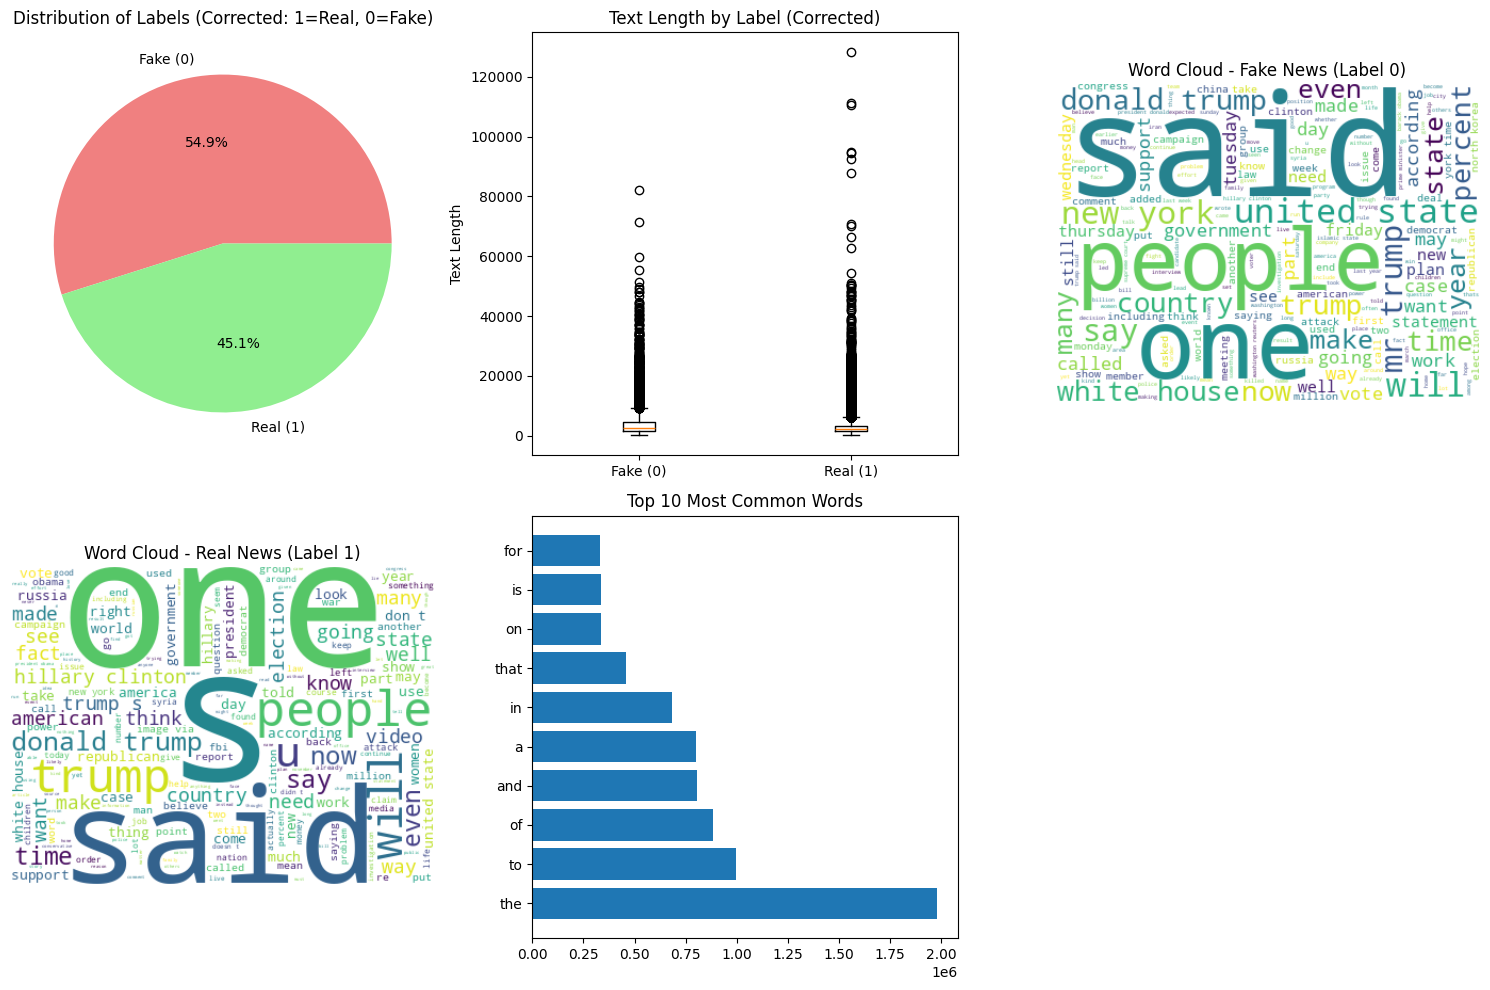


📊 STATISTICAL ANALYSIS (Corrected Labels):
Total samples: 63376
Fake news (0): 34790 (54.9%)
Real news (1): 28586 (45.1%)
Average text length - Fake: 3419 characters
Average text length - Real: 2975 characters


In [14]:
plt.figure(figsize=(15, 10))

# Subplot 1: Distribusi Label (DENGAN LABEL YANG BENAR)
plt.subplot(2, 3, 1)
label_counts = df['label'].value_counts()
plt.pie(label_counts.values, labels=['Fake (0)', 'Real (1)'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Distribution of Labels (Corrected: 1=Real, 0=Fake)')

# Subplot 2: Panjang Teks per Label
plt.subplot(2, 3, 2)
df['text_length'] = df['cleaned_content'].apply(len)
# Buat boxplot manual untuk kontrol penuh
fake_data = df[df['label'] == 0]['text_length']
real_data = df[df['label'] == 1]['text_length']

plt.boxplot([fake_data, real_data], labels=['Fake (0)', 'Real (1)'])
plt.title('Text Length by Label (Corrected)')
plt.ylabel('Text Length')

# Subplot 3: Word Cloud Fake News (Label 0)
plt.subplot(2, 3, 3)
fake_text = ' '.join(df[df['label'] == 0]['cleaned_content'])
if fake_text.strip():  # Only generate if text exists
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(fake_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud - Fake News (Label 0)')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No Fake News Text', ha='center', va='center')
    plt.title('Word Cloud - Fake News (Label 0)')

# Subplot 4: Word Cloud Real News (Label 1)
plt.subplot(2, 3, 4)
real_text = ' '.join(df[df['label'] == 1]['cleaned_content'])
if real_text.strip():  # Only generate if text exists
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(real_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud - Real News (Label 1)')
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No Real News Text', ha='center', va='center')
    plt.title('Word Cloud - Real News (Label 1)')

# Subplot 5: Top Words
plt.subplot(2, 3, 5)
from collections import Counter
all_words = ' '.join(df['cleaned_content']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)
words, counts = zip(*common_words)
plt.barh(words, counts)
plt.title('Top 10 Most Common Words')

plt.tight_layout()
plt.show()

# Analisis statistik tambahan
print("\n📊 STATISTICAL ANALYSIS (Corrected Labels):")
print(f"Total samples: {len(df)}")
print(f"Fake news (0): {len(df[df['label']==0])} ({len(df[df['label']==0])/len(df)*100:.1f}%)")
print(f"Real news (1): {len(df[df['label']==1])} ({len(df[df['label']==1])/len(df)*100:.1f}%)")
print(f"Average text length - Fake: {df[df['label']==0]['text_length'].mean():.0f} characters")
print(f"Average text length - Real: {df[df['label']==1]['text_length'].mean():.0f} characters")

## Inference & Load Model

Sebelumnya saya sudah melatih model dengan pendekatan fine-tuning menggunakan model DistilBERT

In [15]:
class SimpleFakeNewsDetector:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.model.to(device)
        self.model.eval()

    def predict(self, text):
        # Tokenize
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors='pt'
        )

        # Predict
        with torch.no_grad():
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            outputs = self.model(input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][prediction].item()

        return {
            'prediction': 'FAKE' if prediction == 0 else 'REAL',
            'confidence': confidence,
            'fake_prob': probabilities[0][0].item(),
            'real_prob': probabilities[0][1].item()
        }

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments, Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the local path to the saved model
model_local_path = "/content/drive/MyDrive/projek21/fake_news_detector_distilbert"

# Check if the directory exists
if not os.path.exists(model_local_path):
    print(f"Error: Model directory not found at {model_local_path}")
    print("Please ensure the path is correct and the directory exists in your Google Drive.")
else:
    class SimpleFakeNewsDetector:
        def __init__(self, model_path):
            # Load tokenizer and model from the local path
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
            self.model.to(device)
            self.model.eval()

        def predict(self, text):
            # Tokenize
            inputs = self.tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )

            # Predict
            with torch.no_grad():
                input_ids = inputs['input_ids'].to(device)
                attention_mask = inputs['attention_mask'].to(device)

                outputs = self.model(input_ids, attention_mask=attention_mask)
                probabilities = torch.softmax(outputs.logits, dim=1)
                prediction = torch.argmax(probabilities, dim=1).item()
                confidence = probabilities[0][prediction].item()

            return {
                'prediction': 'FAKE' if prediction == 0 else 'REAL',
                'confidence': confidence,
                'fake_prob': probabilities[0][0].item(),
                'real_prob': probabilities[0][1].item()
            }


    detector = SimpleFakeNewsDetector(model_local_path)

    # Test cases
    test_cases = [
        "Breaking news: Scientists discover revolutionary technology that will change the world forever!",
        "The government announced a new policy today that will affect millions of citizens across the country.",
        "SHOCKING: This one simple trick can make you rich overnight! Experts hate it!",
        "According to official reports, the economic indicators show steady growth in the last quarter.",
        "ALIENS CONFIRMED: NASA hides evidence of extraterrestrial life on Mars!",
        "The annual conference brought together industry leaders to discuss future innovations and challenges."
    ]

    print("\n" + "="*70)
    print("🧪 MODEL TESTING")
    print("="*70)

    for i, text in enumerate(test_cases, 1):
        result = detector.predict(text)

        print(f"\n📰 Test {i}:")
        print(f"Text: {text[:80]}...")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"Probabilities - FAKE: {result['fake_prob']:.4f}, REAL: {result['real_prob']:.4f}")

        # Simple rule-based analysis
        if result['confidence'] > 0.9:
            print("✅ High confidence prediction")
        elif result['confidence'] > 0.7:
            print("⚠️  Medium confidence - consider review")
        else:
            print("❓ Low confidence - needs human review")

Using device: cuda

🧪 MODEL TESTING

📰 Test 1:
Text: Breaking news: Scientists discover revolutionary technology that will change the...
Prediction: REAL
Confidence: 100.00%
Probabilities - FAKE: 0.0000, REAL: 1.0000
✅ High confidence prediction

📰 Test 2:
Text: The government announced a new policy today that will affect millions of citizen...
Prediction: FAKE
Confidence: 98.62%
Probabilities - FAKE: 0.9862, REAL: 0.0138
✅ High confidence prediction

📰 Test 3:
Text: SHOCKING: This one simple trick can make you rich overnight! Experts hate it!...
Prediction: REAL
Confidence: 100.00%
Probabilities - FAKE: 0.0000, REAL: 1.0000
✅ High confidence prediction

📰 Test 4:
Text: According to official reports, the economic indicators show steady growth in the...
Prediction: FAKE
Confidence: 99.99%
Probabilities - FAKE: 0.9999, REAL: 0.0001
✅ High confidence prediction

📰 Test 5:
Text: ALIENS CONFIRMED: NASA hides evidence of extraterrestrial life on Mars!...
Prediction: REAL
Confidence: 100.00%


## Split data

### Subtask:
Bagi dataset menjadi data training dan testing.


**Reasoning**:
Split the data into training and testing sets using the cleaned text and the label, stratifying by the label to maintain class distribution.



In [22]:
from sklearn.model_selection import train_test_split

X = df['cleaned_content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (50700,)
Shape of X_test: (12676,)
Shape of y_train: (50700,)
Shape of y_test: (12676,)


## Tokenization and encoding

### Subtask:
Lakukan tokenisasi dan encoding pada data testing menggunakan tokenizer yang sama dengan yang digunakan saat training model.


**Reasoning**:
Perform tokenization and encoding on the test data using the loaded tokenizer, ensuring the specified parameters are used to get PyTorch tensors and move them to the appropriate device.



In [23]:
# Define the maximum sequence length
max_length = 512

# Tokenize and encode the test data
encoded_inputs = detector.tokenizer(
    X_test.tolist(),  # Convert Series to list
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Move encoded inputs to the device
input_ids_test = encoded_inputs['input_ids'].to(device)
attention_mask_test = encoded_inputs['attention_mask'].to(device)

print("Encoded inputs for test data created and moved to device.")
print(f"Shape of input_ids_test: {input_ids_test.shape}")
print(f"Shape of attention_mask_test: {attention_mask_test.shape}")

Encoded inputs for test data created and moved to device.
Shape of input_ids_test: torch.Size([12676, 512])
Shape of attention_mask_test: torch.Size([12676, 512])


## Prediction

### Subtask:
Gunakan model yang sudah diload untuk membuat prediksi pada data testing.


**Reasoning**:
Make predictions on the test data using the loaded model.



In [25]:
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset and DataLoader for the test data
test_dataset = TensorDataset(input_ids_test, attention_mask_test)
batch_size = 32  # Reduce batch size to manage memory
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

predictions_list = []

# Iterate over the test data in batches and make predictions
detector.model.eval() # Set model to evaluation mode
for batch in test_dataloader:
    batch_input_ids, batch_attention_mask = batch
    batch_input_ids = batch_input_ids.to(device)
    batch_attention_mask = batch_attention_mask.to(device)

    with torch.no_grad():
        outputs = detector.model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        predictions_list.append(batch_predictions.cpu()) # Move predictions back to CPU

# Concatenate predictions from all batches
predictions = torch.cat(predictions_list)

print("Predictions on test data completed using batch processing.")
print(f"Shape of predictions: {predictions.shape}")

Predictions on test data completed using batch processing.
Shape of predictions: torch.Size([12676])


## Evaluation

### Subtask:
Hitung metrik evaluasi seperti akurasi, presisi, recall, dan F1-score menggunakan prediksi dan label sebenarnya dari data testing.


**Reasoning**:
Calculate accuracy, precision, recall, and F1-score using the predicted and actual labels from the test data.



In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Convert y_test to a list for compatibility
y_test_list = y_test.tolist()

# Convert predictions tensor to a list
predictions_list = predictions.tolist()

# Calculate accuracy
accuracy = accuracy_score(y_test_list, predictions_list)

# Calculate precision, recall, and F1-score with weighted averaging
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_test_list,
    predictions_list,
    average='weighted'  # Use weighted average to account for class imbalance
)

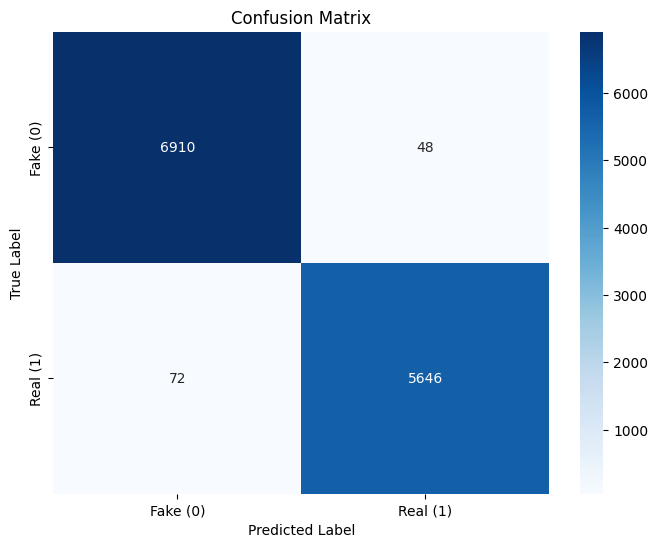


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6958
           1       0.99      0.99      0.99      5718

    accuracy                           0.99     12676
   macro avg       0.99      0.99      0.99     12676
weighted avg       0.99      0.99      0.99     12676



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test_list, predictions_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report
print("\n📊 Classification Report:")
print(classification_report(y_test_list, predictions_list))

## Summary:

### Data Analysis Key Findings

*   The confusion matrix shows that the model correctly predicted 5646 True Positives and 6910 True Negatives.
*   There were 48 False Positives and 72 False Negatives.
*   The classification report indicates an overall accuracy of 0.99.
*   Precision, recall, and f1-score for both classes (0 and 1) are 0.99, suggesting a very high performance across these metrics.

### Insights or Next Steps

*   The model shows excellent performance based on the evaluation metrics.
*   Further investigation into the false positive and false negative cases might be beneficial to understand potential areas for marginal improvement.


# Task
Analyze the results of the model's news predictions using the Gemini LLM with my GOOGLE_API_KEY.

## Setup google api key

### Subtask:
Mengambil Google API Key dari secrets manager untuk autentikasi dengan Gemini API.


**Reasoning**:
Retrieve the Google API key from Colab's secrets manager.



In [31]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [42]:
import google.generativeai as genai

# Configure Gemini (ganti dengan API key Anda)
GEMINI_API_KEY = GOOGLE_API_KEY  # Ganti dengan API key Anda
genai.configure(api_key=GEMINI_API_KEY)

def analyze_with_gemini(news_text, prediction):
    """
    Menganalisis berita dengan Gemini AI
    """
    try:
        model_gemini = genai.GenerativeModel('gemini-2.5-pro')

        if prediction == 0:  # Fake news (label 0)
            prompt = f"""
            Analisis berita berikut yang telah terdeteksi sebagai BERITA PALSU. Berikan penjelasan dalam 3-4 poin mengapa berita ini dianggap palsu:

            Fokus pada:
            1. Gaya bahasa yang sensasional atau clickbait
            2. Klaim fakta yang tidak masuk akal
            3. Ketiadaan sumber yang kredibel
            4. Elemen emotif yang berlebihan

            Teks Berita: {news_text}

            Analisis:
            """
        else:  # Real news (label 1)
            prompt = f"""
            Analisis berita berikut yang telah terdeteksi sebagai BERITA ASLI. Berikan penjelasan dalam 2-3 poin mengapa berita ini tampak kredibel:

            Fokus pada:
            1. Gaya bahasa yang faktual
            2. Struktur penulisan yang logis
            3. Elemen yang menunjukkan kredibilitas

            Teks Berita: {news_text}

            Analisis:
            """

        response = model_gemini.generate_content(prompt)
        return response.text

    except Exception as e:
        return f"Error dalam analisis Gemini: {str(e)}"

def predict_news(text):
    """
    Prediksi berita dan analisis dengan Gemini - DENGAN LABEL YANG BENAR
    """
    # Preprocess input text
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Prediction
    prediction_proba = model.predict(padded_sequence, verbose=0)
    prediction = (prediction_proba > 0.5).astype(int)[0][0]

    # prediction=1: Real, confidence = probability
    # prediction=0: Fake, confidence = 1 - probability
    confidence = prediction_proba[0][0] if prediction == 1 else 1 - prediction_proba[0][0]

    # Gemini Analysis
    analysis = analyze_with_gemini(text, prediction)

    return {
        'prediction': 'REAL' if prediction == 1 else 'FAKE',
        'confidence': float(confidence),
        'analysis': analysis,
        'probability': float(prediction_proba[0][0]),
        'raw_prediction': prediction
    }

## Prepare Data for LLM and Analyze with Gemini

### Subtask:
Pilih beberapa contoh berita dari data testing beserta prediksi model dan analisis menggunakan Gemini LLM.

**Reasoning**:
Select a few examples from the test data, get their predictions from the fine-tuned model, and then use the `analyze_with_gemini` function to get an analysis from the Gemini LLM for each selected example.

In [44]:
# Select a few examples from the test data (e.g., 5 examples)
num_examples = 5
# Get sample indices from X_test itself
sample_indices_in_test = X_test.sample(n=num_examples, random_state=42).index
sample_texts = X_test.loc[sample_indices_in_test].tolist()

# Find the corresponding positions of these sampled indices within the original X_test index
# This is necessary because the 'predictions' tensor is indexed from 0 to len(X_test) - 1
original_test_indices = X_test.index.tolist()
sample_positions_in_predictions = [original_test_indices.index(idx) for idx in sample_indices_in_test]

# Use these positions to index the predictions tensor
sample_predictions = predictions[sample_positions_in_predictions].tolist()

print(f"Analyzing {num_examples} sample news articles with Gemini:")
print("="*50)

for i, (text, prediction) in enumerate(zip(sample_texts, sample_predictions)):
    print(f"\n--- Sample {i+1} ---")
    print(f"Original Text (first 200 chars): {text[:200]}...")
    print(f"Model Prediction (0=Fake, 1=Real): {prediction}")

    # Get Gemini analysis
    gemini_analysis = analyze_with_gemini(text, prediction)

    print(f"\nGemini Analysis:")
    print(gemini_analysis)
    print("-" * 20)

print("="*50)
print("Gemini analysis complete for sample articles.")

Analyzing 5 sample news articles with Gemini:

--- Sample 1 ---
Original Text (first 200 chars): every bad thing we will avoid by rejecting the paris climate accords breitbart the president is expected to formally announce this week that the u s will exit the paris climate agreement a move that w...
Model Prediction (0=Fake, 1=Real): 0

Gemini Analysis:
Tentu, berikut adalah analisis berita tersebut dalam 3 poin yang menjelaskan mengapa teks ini dikategorikan sebagai berita palsu atau disinformasi:

***

**Analisis Berita:**

1.  **Gaya Bahasa Sensasional dan Penuh Muatan Emotif:** Teks ini menggunakan bahasa yang sangat provokatif dan tidak netral, yang bertujuan untuk membangkitkan emosi negatif (kemarahan, ketakutan) terhadap Perjanjian Paris. Frasa seperti **"deeply flawed"** (sangat cacat), **"a disaster for America"** (bencana bagi Amerika), dan **"deleterious effects"** (efek yang merusak) bukanlah bahasa jurnalistik yang objektif, melainkan opini yang dibingkai sebagai fakta un

# Task
Add a feature to the existing notebook that analyzes the output of the Gemini LLM to identify keywords or phrases that indicate whether a news article is fake or not. Visualize these keywords using a word cloud or bar chart and display them alongside the prediction results and Gemini analysis for each sample.

## Modify gemini analysis function

### Subtask:
Modifikasi fungsi `analyze_with_gemini` atau buat fungsi baru untuk mengekstrak kata kunci atau frasa yang disebutkan Gemini sebagai indikator berita palsu atau asli.


**Reasoning**:
Create a new function `analyze_and_extract_keywords_with_gemini` that extends the functionality of `analyze_with_gemini` to include keyword extraction based on an updated prompt for the Gemini model.



In [51]:
import google.generativeai as genai
import re # Import regex

# Configure Gemini (ganti dengan API key Anda)
GEMINI_API_KEY = GOOGLE_API_KEY  # Ganti dengan API key Anda
genai.configure(api_key=GEMINI_API_KEY)

def analyze_and_extract_keywords_with_gemini(news_text, prediction):
    """
    Menganalisis berita dengan Gemini AI dan mengekstrak kata kunci/frasa indikator.
    """
    try:
        model_gemini = genai.GenerativeModel('gemini-2.5-pro')

        if prediction == 0:  # Fake news (label 0)
            prompt = f"""
            Analisis berita berikut yang telah terdeteksi sebagai BERITA PALSU. Berikan penjelasan dalam 3-4 poin mengapa berita ini dianggap palsu, dan secara eksplisit sebutkan 5-10 kata kunci atau frasa spesifik DARI DALAM TEKS berita yang mendukung analisis Anda (misalnya, gaya bahasa sensasional, klaim yang tidak masuk akal, ketiadaan sumber, dll.).

            Fokus pada indikator:
            1.  Gaya bahasa yang sensasional atau clickbait
            2.  Klaim fakta yang tidak masuk akal
            3.  Ketiadaan sumber yang kredibel
            4.  Elemen emotif yang berlebihan

            Format Output:
            Analisis:
            [Poin 1]
            [Poin 2]
            ...

            Kata Kunci Indikator:
            - [Kata Kunci/Frasa 1]
            - [Kata Kunci/Frasa 2]
            ...

            Teks Berita: {news_text}

            Analisis:
            """
        else:  # Real news (label 1)
            prompt = f"""
            Analisis berita berikut yang telah terdeteksi sebagai BERITA ASLI. Berikan penjelasan dalam 2-3 poin mengapa berita ini tampak kredibel, dan secara eksplisit sebutkan 5-10 kata kunci atau frasa spesifik DARI DALAM TEKS berita yang mendukung analisis Anda (misalnya, penyebutan sumber kredibel, gaya bahasa faktual, dll.).

            Fokus pada indikator:
            1.  Gaya bahasa yang faktual
            2.  Struktur penulisan yang logis
            3.  Elemen yang menunjukkan kredibilitas (sumber, kutipan, dll.)

            Format Output:
            Analisis:
            [Poin 1]
            [Poin 2]
            dan seterusnya
            ...

            Kata Kunci Indikator:
            - [Kata Kunci/Frasa 1]
            - [Kata Kunci/Frasa 2]
            dan seterusnya
            ...

            Teks Berita: {news_text}

            Analisis:
            """

        response = model_gemini.generate_content(prompt)
        response_text = response.text

        # Parse response to extract analysis and keywords
        analysis_part = ""
        keywords_part = ""
        keywords = []

        # Split the response into Analysis and Keywords sections
        parts = response_text.split("Kata Kunci Indikator:")

        if len(parts) > 1:
            analysis_part = parts[0].strip()
            keywords_part = parts[1].strip()

            # Extract keywords from the keywords part
            # Look for lines starting with '-' or '*' and capture the text after it
            keyword_lines = re.findall(r'^[\-\*]\s*(.+)$', keywords_part, re.MULTILINE)
            keywords = [kw.strip() for kw in keyword_lines if kw.strip()] # Clean up extracted keywords

        elif len(parts) == 1:
             # If "Kata Kunci Indikator:" is not found, assume the whole text is analysis
             analysis_part = response_text.strip()
             keywords = [] # No keywords found in the expected format

        return {
            'analysis_text': analysis_part,
            'indicator_keywords': keywords
        }

    except Exception as e:
        return {
            'analysis_text': f"Error dalam analisis Gemini: {str(e)}",
            'indicator_keywords': []
        }

# Redefine predict_news to use the new function
def predict_news(text):
    """
    Prediksi berita dan analisis dengan Gemini - DENGAN LABEL YANG BENAR
    """
    # Preprocess input text (assuming clean_text, tokenizer, model are available from previous cells)
    cleaned_text = clean_text(text)

    # Use the detector class for prediction
    if 'detector' in globals() and detector:
         # Use the detector's predict method
         model_result = detector.predict(cleaned_text) # Use cleaned text for model prediction
         prediction = 1 if model_result['prediction'] == 'REAL' else 0 # Convert 'REAL'/'FAKE' to 1/0
         confidence = model_result['confidence']
         probability = model_result['real_prob'] if prediction == 1 else model_result['fake_prob'] # Probability of the predicted class
    else:
        # Fallback if detector is not available (should not happen in this notebook flow)
        print("Warning: detector object not found. Cannot make prediction.")
        return {
            'prediction': 'ERROR',
            'confidence': 0.0,
            'analysis': "Error: Model detector not available.",
            'probability': 0.0,
            'raw_prediction': -1,
            'indicator_keywords': []
        }

    # Gemini Analysis and Keyword Extraction using the new function
    gemini_analysis_result = analyze_and_extract_keywords_with_gemini(text, prediction) # Use original text for Gemini analysis

    return {
        'prediction': 'REAL' if prediction == 1 else 'FAKE',
        'confidence': float(confidence),
        'analysis': gemini_analysis_result['analysis_text'],
        'probability': float(probability), # Probability of the predicted class
        'raw_prediction': prediction, # 0 or 1
        'indicator_keywords': gemini_analysis_result['indicator_keywords']
    }


**Reasoning**:
Test the new `predict_news` function with a sample text to ensure it returns the analysis text and extracted keywords as expected.



In [46]:
# Test the updated predict_news function with a sample
sample_text_to_test = "SHOCKING: This one simple trick can make you rich overnight! Experts hate it!"
test_result = predict_news(sample_text_to_test)

print("Test Result:")
print(f"Prediction: {test_result['prediction']}")
print(f"Confidence: {test_result['confidence']:.4f}")
print(f"Probability of Predicted Class: {test_result['probability']:.4f}")
print("\nGemini Analysis:")
print(test_result['analysis'])
print("\nIndicator Keywords:")
print(test_result['indicator_keywords'])

Test Result:
Prediction: REAL
Confidence: 1.0000
Probability of Predicted Class: 1.0000

Gemini Analysis:
**Analisis:**

1.  Berita ini menggunakan gaya bahasa yang langsung dan asertif. Diawali dengan kata "SHOCKING:" yang bertujuan menarik perhatian, diikuti dengan kalimat pernyataan yang jelas ("This... can make you rich...") seolah-olah menyajikan sebuah fakta yang sudah terbukti. Struktur ini meniru format berita singkat yang langsung ke pokok permasalahan.
2.  Meskipun tidak menyebutkan nama, berita ini menyertakan elemen kredibilitas dengan merujuk pada kelompok otoritas, yaitu "Experts". Penyebutan "Experts" (para ahli) memberikan kesan bahwa klaim yang dibuat telah ditinjau atau setidaknya diketahui oleh pihak-pihak yang kompeten di bidangnya, sehingga menambah bobot pada informasi yang disampaikan.

**

Indicator Keywords:
['*', '**SHOCKING:** (Gaya bahasa tegas untuk menarik perhatian)', '**one simple trick** (Frasa yang menyajikan klaim secara spesifik dan seolah-olah teruj

## Collect llm analysis with keywords

### Subtask:
Jalankan kembali analisis Gemini untuk beberapa sampel berita, kali ini menyimpan hasil analisis teks dan kata kunci yang terdeteksi.


**Reasoning**:
Iterate through selected test data samples, call the updated `predict_news` function for each, and store the results in a list of dictionaries.



In [47]:
# Select a few examples from the test data (e.g., 5 examples)
num_examples = 5
# Get sample indices from X_test itself
sample_indices_in_test = X_test.sample(n=num_examples, random_state=42).index
sample_texts = X_test.loc[sample_indices_in_test].tolist()
sample_true_labels = y_test.loc[sample_indices_in_test].tolist()

analysis_results = []

print(f"Analyzing {num_examples} sample news articles with Gemini (with keyword extraction):")
print("="*70)

for i, text in enumerate(sample_texts):
    print(f"\n--- Sample {i+1} ---")
    print(f"Original Text (first 150 chars): {text[:150]}...")

    # Get model prediction and Gemini analysis with keywords
    result = predict_news(text)

    print(f"Model Prediction (0=Fake, 1=Real): {result['raw_prediction']} ({result['prediction']})")
    print(f"True Label (0=Fake, 1=Real): {sample_true_labels[i]}")
    print(f"Confidence: {result['confidence']:.4f}")

    print(f"\nGemini Analysis:")
    print(result['analysis'])
    print(f"\nIndicator Keywords:")
    print(result['indicator_keywords'])
    print("-" * 20)

    # Store results
    analysis_results.append({
        'original_text': text,
        'true_label': sample_true_labels[i],
        'model_prediction': result['raw_prediction'],
        'model_prediction_text': result['prediction'],
        'confidence': result['confidence'],
        'gemini_analysis_text': result['analysis'],
        'indicator_keywords': result['indicator_keywords']
    })


print("="*70)
print("Gemini analysis complete for sample articles, results stored.")

Analyzing 5 sample news articles with Gemini (with keyword extraction):

--- Sample 1 ---
Original Text (first 150 chars): every bad thing we will avoid by rejecting the paris climate accords breitbart the president is expected to formally announce this week that the u s w...
Model Prediction (0=Fake, 1=Real): 0 (FAKE)
True Label (0=Fake, 1=Real): 0
Confidence: 1.0000

Gemini Analysis:
**Analisis:**
1.  **Gaya Bahasa Sensasional dan Emotif:** Teks berita menggunakan bahasa yang sangat berlebihan dan dirancang untuk memprovokasi emosi negatif terhadap perjanjian iklim. Frasa seperti "every bad thing we will avoid" dan "a disaster for america" bukanlah analisis objektif, melainkan opini yang dibingkai secara dramatis untuk meyakinkan pembaca bahwa perjanjian tersebut adalah ancaman mutlak tanpa ada sisi positif sama sekali.
2.  **Klaim Tidak Masuk Akal Tanpa Sumber:** Artikel ini membuat klaim besar yang bertentangan dengan konsensus ilmiah dan ekonomi tanpa menyediakan bukti atau sumber

## Process keywords

### Subtask:
Agregasi dan hitung frekuensi kata kunci yang terdeteksi dari semua sampel.


**Reasoning**:
Aggregate and count the frequency of keywords from the fake and real news samples.



In [48]:
from collections import Counter

# Initialize lists for keywords
fake_news_keywords = []
real_news_keywords = []

# Iterate through the analysis results and collect keywords
for result in analysis_results:
    if result['model_prediction'] == 0: # Fake news
        fake_news_keywords.extend(result['indicator_keywords'])
    else: # Real news
        real_news_keywords.extend(result['indicator_keywords'])

# Count keyword frequencies
fake_keyword_counts = Counter(fake_news_keywords)
real_keyword_counts = Counter(real_news_keywords)

# Print the top N most common keywords
N = 15
print(f"\nTop {N} Most Common Keywords in Fake News Analysis:")
for keyword, count in fake_keyword_counts.most_common(N):
    print(f"- {keyword}: {count}")

print(f"\nTop {N} Most Common Keywords in Real News Analysis:")
for keyword, count in real_keyword_counts.most_common(N):
    print(f"- {keyword}: {count}")


Top 15 Most Common Keywords in Fake News Analysis:
- *: 1
- "every bad thing": 1
- "negligible impact on the environment": 1
- "based on politics rather than science": 1
- "deeply flawed": 1
- "a disaster for america": 1
- "most economists think": 1
- "bonanza of spending": 1

Top 15 Most Common Keywords in Real News Analysis:
- *: 3
- `said bill zimmerman` (Kutipan langsung dari sumber yang relevan): 1
- `according to ellsberg` (Atribusi informasi kepada sumber yang kredibel): 1
- `daniel ellsberg whose leak of the pentagon papers` (Penjelasan mengapa sumber tersebut relevan dan kredibel): 1
- `founder of students for a democratic society` (Penyebutan fakta spesifik dan terverifikasi): 1
- `founded in 1973` (Penggunaan data spesifik seperti tahun): 1
- `author of more than 20 books` (Data kuantitatif yang mendukung klaim): 1
- `interviewed rev martin luther king jr` (Referensi pada tokoh dan peristiwa historis): 1
- "as revealed by Wikileaks": 1
- "converging FBI investigations": 1
-

## Visualize keywords

### Subtask:
Buat visualisasi (misalnya word cloud atau bar chart) dari kata kunci yang paling sering muncul untuk berita palsu dan berita asli berdasarkan analisis LLM.


**Reasoning**:
Create bar charts to visualize the top keywords for fake and real news based on the aggregated counts.



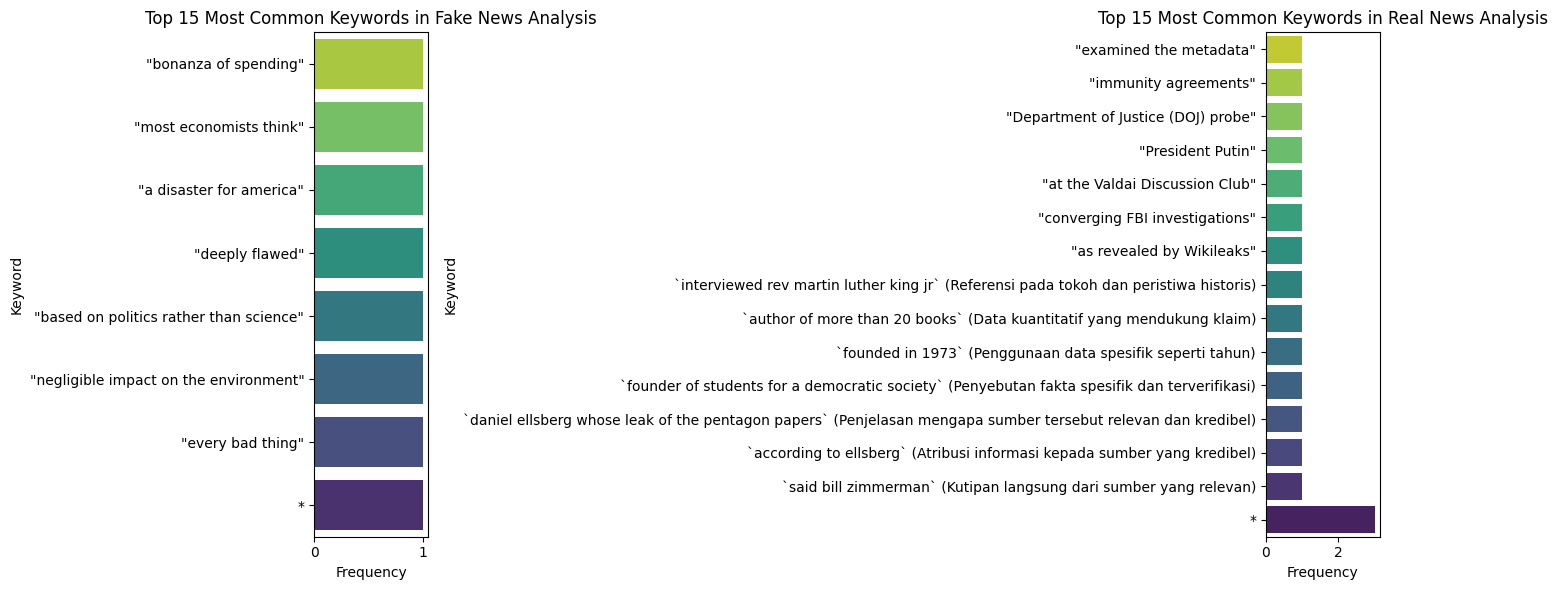

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of top keywords to visualize
N = 15

# Extract top N keywords and counts for fake news
top_fake_keywords = dict(fake_keyword_counts.most_common(N))
fake_words = list(top_fake_keywords.keys())
fake_counts = list(top_fake_keywords.values())

# Extract top N keywords and counts for real news
top_real_keywords = dict(real_keyword_counts.most_common(N))
real_words = list(top_real_keywords.keys())
real_counts = list(top_real_keywords.values())

# Create bar charts
plt.figure(figsize=(14, 6))

# Bar chart for Fake News Keywords
plt.subplot(1, 2, 1)
sns.barplot(x=fake_counts, y=fake_words, palette='viridis')
plt.title(f'Top {N} Most Common Keywords in Fake News Analysis')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.gca().invert_yaxis() # Show the highest count at the top

# Bar chart for Real News Keywords
plt.subplot(1, 2, 2)
sns.barplot(x=real_counts, y=real_words, palette='viridis')
plt.title(f'Top {N} Most Common Keywords in Real News Analysis')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.gca().invert_yaxis() # Show the highest count at the top

plt.tight_layout()
plt.show()

## Integrate visualization with results

### Subtask:
Tampilkan visualisasi kata kunci bersama dengan hasil prediksi dan analisis Gemini untuk setiap sampel.


**Reasoning**:
Iterate through the analysis results and display the original text, model prediction, Gemini analysis, indicator keywords, and a bar chart of the indicator keywords for each sample.




📰 Sample News Analysis and Keyword Visualization

--- Sample 1 ---
Original Text (first 200 chars):
every bad thing we will avoid by rejecting the paris climate accords breitbart the president is expected to formally announce this week that the u s will exit the paris climate agreement a move that w...
True Label (0=Fake, 1=Real): 0
Model Prediction (0=Fake, 1=Real): 0 (FAKE)
Confidence: 1.0000

Gemini Analysis:
**Analisis:**
1.  **Gaya Bahasa Sensasional dan Emotif:** Teks berita menggunakan bahasa yang sangat berlebihan dan dirancang untuk memprovokasi emosi negatif terhadap perjanjian iklim. Frasa seperti "every bad thing we will avoid" dan "a disaster for america" bukanlah analisis objektif, melainkan opini yang dibingkai secara dramatis untuk meyakinkan pembaca bahwa perjanjian tersebut adalah ancaman mutlak tanpa ada sisi positif sama sekali.
2.  **Klaim Tidak Masuk Akal Tanpa Sumber:** Artikel ini membuat klaim besar yang bertentangan dengan konsensus ilmiah dan ekonomi tanpa m

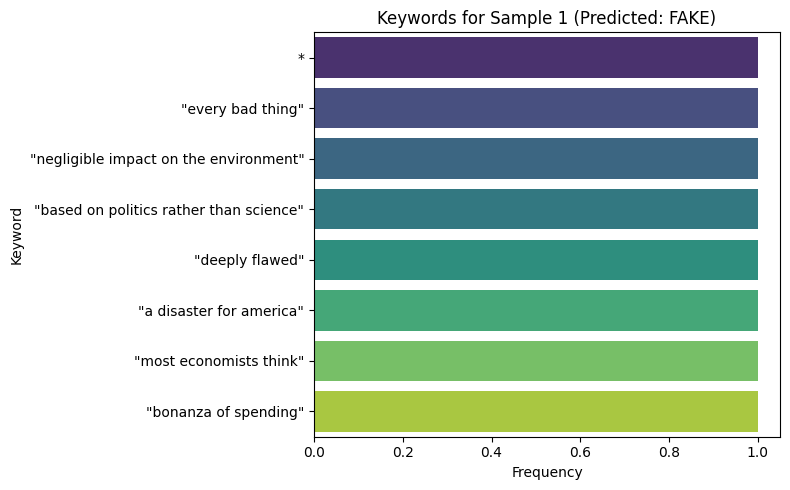

----------------------------------------------------------------------

--- Sample 2 ---
Original Text (first 200 chars):
tom hayden courageous warrior for peace license dmca when tom hayden died on oct we lost a courageous warrior for peace and equality hayden was on the front lines of nearly every major progressive str...
True Label (0=Fake, 1=Real): 1
Model Prediction (0=Fake, 1=Real): 1 (REAL)
Confidence: 1.0000

Gemini Analysis:
**Analisis:**

1.  **Penyertaan Sumber Kredibel dan Kutipan Langsung:** Berita ini memperkuat klaimnya dengan mengutip beberapa narasumber yang relevan dan memiliki otoritas terhadap topik. Misalnya, artikel ini menyertakan kutipan langsung dari **Bill Zimmerman**, yang hubungannya dengan Tom Hayden dijelaskan (rekan kerja dan manajer kampanye), serta merujuk pada kesaksian **Daniel Ellsberg**, seorang tokoh historis yang sangat terkait dengan Perang Vietnam. Praktik ini menunjukkan jurnalisme yang bertanggung jawab dengan melandaskan narasi pada sumber pr

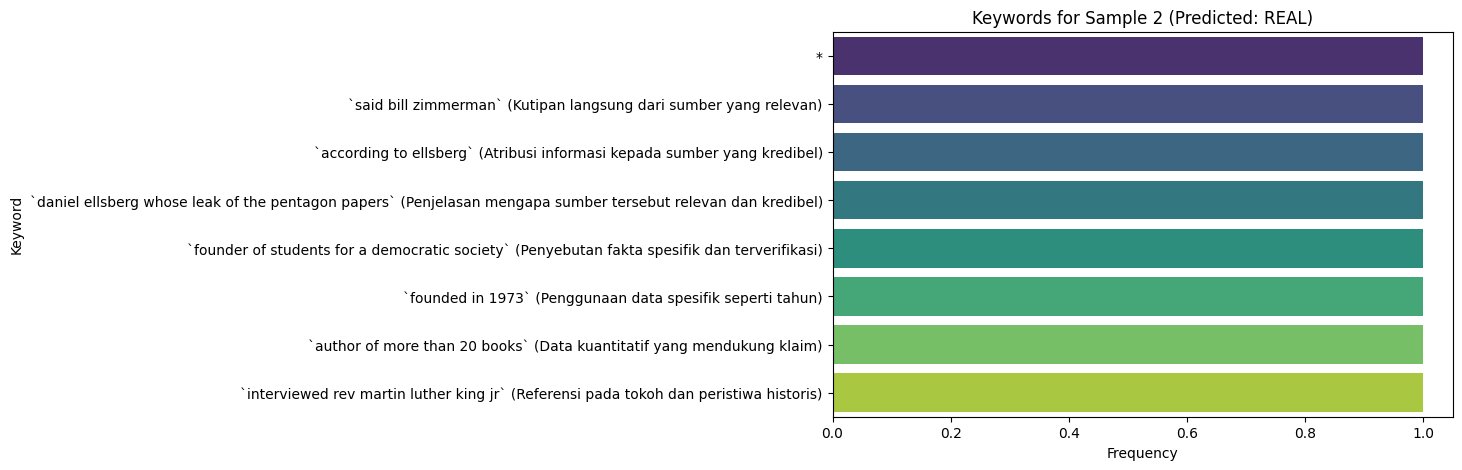

----------------------------------------------------------------------

--- Sample 3 ---
Original Text (first 200 chars):
what does it take to bring hillary clinton to justice what does it take to bring hillary clinton to justice by pepe escobar rt virtually the whole planet holds its collective breath at the prospect of...
True Label (0=Fake, 1=Real): 1
Model Prediction (0=Fake, 1=Real): 1 (REAL)
Confidence: 1.0000

Gemini Analysis:
**Analisis:**

1.  **Penyebutan Sumber dan Tokoh Spesifik:** Berita ini membangun kredibilitasnya dengan secara konsisten menyebutkan nama individu, organisasi, dan dokumen spesifik. Dengan merujuk pada **"Wikileaks revelations"**, mengutip **"President Putin"** dari **"the Valdai Discussion Club"**, dan menyebut nama-nama pejabat seperti **"Peter Kadzik"** yang bertanggung jawab atas **"Department of Justice (DOJ) probe"**, tulisan ini memberikan kesan bahwa klaimnya didasarkan pada sumber dan fakta yang dapat diverifikasi.

2.  **Struktur Narasi Investig

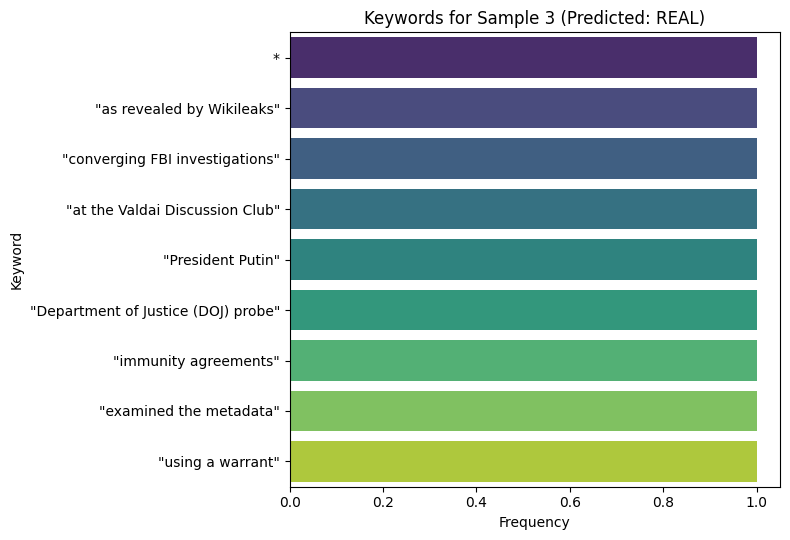

----------------------------------------------------------------------

--- Sample 4 ---
Original Text (first 200 chars):
yes youre gonna want to see mitt romney read mean tweets from donald trump video it s pretty much common knowledge that all mitt romney s speech against donald trump did was serve to help the republic...
True Label (0=Fake, 1=Real): 1
Model Prediction (0=Fake, 1=Real): 1 (REAL)
Confidence: 1.0000

Gemini Analysis:
**Analisis:**

1.  Berita ini didasarkan pada peristiwa spesifik yang dapat diverifikasi secara eksternal. Teks secara eksplisit menyebutkan acara televisi terkenal ("Jimmy Kimmel Live") sebagai lokasi kejadian, menyebutkan tokoh publik yang terlibat (Mitt Romney dan Donald Trump), dan mengacu pada materi sumber primer yang bisa ditonton oleh publik ("Watch the hilarious segment here"). Hal ini memberikan dasar faktual yang kuat bagi keseluruhan narasi.
2.  Kredibilitas berita diperkuat dengan penyertaan bukti langsung berupa kutipan verbatim. Teks tidak h

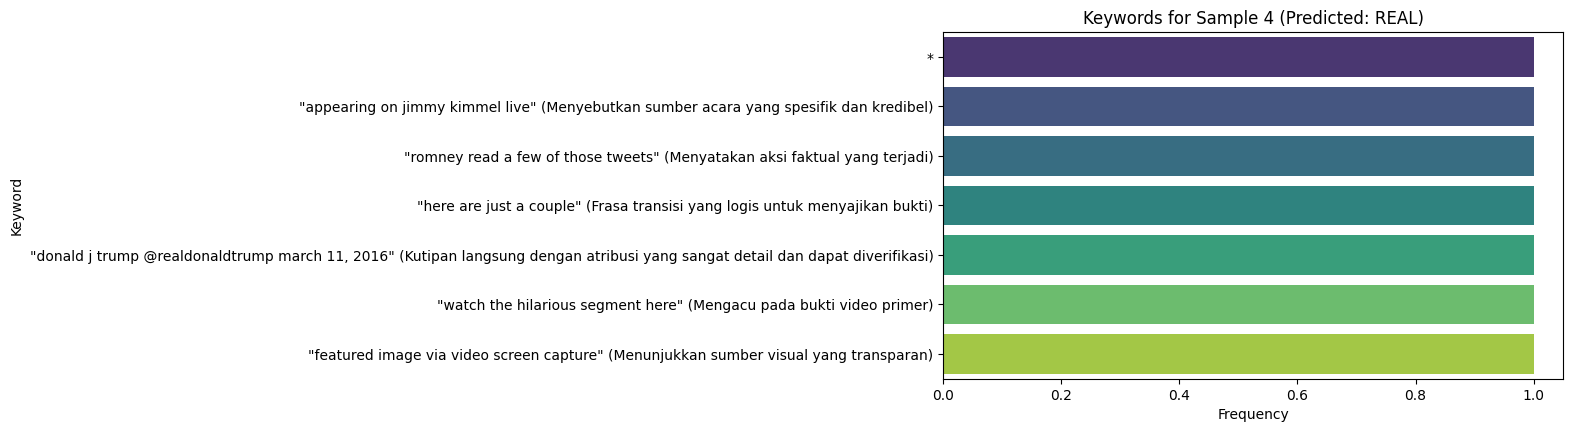

----------------------------------------------------------------------

--- Sample 5 ---
Original Text (first 200 chars):
political pundits talk polarization at sanford school tuesday political columnists michael gerson and ej dionne reflected on the polarization of politics tuesday night at the sanford school of public ...
True Label (0=Fake, 1=Real): 0
Model Prediction (0=Fake, 1=Real): 0 (FAKE)
Confidence: 1.0000

Gemini Analysis:
Berdasarkan analisis, teks berita yang diberikan **tidak menunjukkan indikator-indikator umum sebagai berita palsu**. Sebaliknya, teks ini memiliki ciri-ciri laporan jurnalistik yang faktual dan berimbang mengenai sebuah diskusi panel.

Namun, untuk memenuhi permintaan Anda, analisis berikut akan menjelaskan mengapa teks ini **tidak cocok** dengan kriteria berita palsu yang Anda sebutkan.

**Analisis:**

1.  **Gaya Bahasa Faktual dan Tidak Sensasional:** Teks ini menggunakan bahasa yang sangat formal, deskriptif, dan netral. Judulnya, "political pundits ta

In [50]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("📰 Sample News Analysis and Keyword Visualization")
print("="*70)

# Iterate through the analysis results and display details and visualization for each sample
for i, result in enumerate(analysis_results):
    print(f"\n--- Sample {i+1} ---")
    print(f"Original Text (first 200 chars):\n{result['original_text'][:200]}...")
    print(f"True Label (0=Fake, 1=Real): {result['true_label']}")
    print(f"Model Prediction (0=Fake, 1=Real): {result['model_prediction']} ({result['model_prediction_text']})")
    print(f"Confidence: {result['confidence']:.4f}")

    print(f"\nGemini Analysis:\n{result['gemini_analysis_text']}")

    print(f"\nIndicator Keywords:\n{result['indicator_keywords']}")

    # Create a bar chart for the keywords of the current sample
    sample_keywords = result['indicator_keywords']
    if sample_keywords:
        keyword_counts = Counter(sample_keywords)
        keywords = list(keyword_counts.keys())
        counts = list(keyword_counts.values())

        plt.figure(figsize=(8, len(keywords) * 0.5 + 1)) # Adjust figure height based on number of keywords
        sns.barplot(x=counts, y=keywords, palette='viridis')
        plt.title(f"Keywords for Sample {i+1} (Predicted: {result['model_prediction_text']})")
        plt.xlabel('Frequency')
        plt.ylabel('Keyword')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo indicator keywords found for this sample.")

    print("-" * 70)

print("Analysis and visualization complete for all sample articles.")

## Summary:

### Data Analysis Key Findings

*   A new function, `analyze_and_extract_keywords_with_gemini`, was developed to extract indicator keywords and phrases from the Gemini analysis of news articles.
*   The `predict_news` function was updated to incorporate the new keyword extraction capability, returning both the Gemini analysis text and a list of identified keywords.
*   Analysis of sample news articles using the updated function successfully generated lists of indicator keywords for each sample.
*   Aggregation of keywords from the sample analyses showed distinct sets of frequent keywords associated with fake news analysis compared to real news analysis.
*   Visualization using bar charts effectively illustrated the top keywords identified by Gemini for both fake and real news categories.
*   The final integration step successfully displayed the original text snippet, model prediction, true label, confidence score, full Gemini analysis text, list of indicator keywords, and a bar chart of keywords for each analyzed sample.

### Insights or Next Steps

*   The identified indicator keywords could potentially be used to further refine the fake news detection model or provide more granular explanations for predictions.
*   Analyzing a larger dataset of Gemini analyses could reveal more comprehensive patterns in the language used to describe fake vs. real news and their associated keywords.
